# Transcript Analysis

In [23]:
%load_ext autoreload
%autoreload 2
import os
import re
import sys
import tqdm
import pickle
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def find_transcripts(author_name):
	transcript_dir_path = '_Transcripts'
	for dir in os.listdir(transcript_dir_path):
		# check if dir and if author_name is in dir
		if os.path.isdir(os.path.join(transcript_dir_path, dir)) and author_name in dir:
			print(f'Found {author_name} in {transcript_dir_path}/{dir}.')
			transcript_paths = []
			for file in sorted(os.listdir(os.path.join(transcript_dir_path, dir)), reverse=True):
				transcript_paths.append(os.path.join(transcript_dir_path, dir, file))
			print(f' Found {len(transcript_paths)} transcripts.')
			return transcript_paths
	print(' Transcript Path not Found author:', os.path.join(os.getcwd(), author_name))

def extract_yaml_front_matter(f, transcript_dict, title):
	# capture all the meta data until the next --- is found
	meta_data = ''
	meta_dict = defaultdict(str)
	for line in f:
		if line == '---\n':
			break
		meta_data += line
	# extract all the information with 'header' : 'value' format
	meta_data = meta_data.split('\n')
	for data in meta_data:
		if data != '':
			header, value = data.split(': ')
			meta_dict[header] = value
	return meta_dict

def read_transcript(transcript_name, transcript_dict):
	with open(transcript_name, 'r', encoding='unicode_escape') as f:
		print(f'  Reading: {transcript_name}')
		for line in f:
			# read the .md meta data in YAML Front Matter format --- 
			if line == '---\n':
				meta_dict = extract_yaml_front_matter(f, transcript_dict, title)
				print(meta_dict)
			# title is the first line of the transcript, with # at the beginning
			if line[0] == '#':
				title = line[1:].strip()
			# date is in the second line of the transcript, between [ and ]
			# url is in the second line of the transcript, between ( and )
			elif line[:2] == '**':
				date = re.search(r'\[(.*?)\]', line).group(1)
				# conver date to datetime (December 6, 2023 -> 2023-12-06)
				date = datetime.datetime.strptime(date, '%B %d, %Y').strftime('%Y-%m-%d')
				# add year, month, day to the dict
				year = date[:4]
				month = date[5:7]
				day = date[8:]
				transcript_dict[title]['year'] = year
				transcript_dict[title]['month'] = month
				transcript_dict[title]['day'] = day
				# convert date to day of the week
				weekday = datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%A')
				transcript_dict[title]['weekday'] = weekday
				url = re.search(r'\((.*?)\)', line).group(1)
				transcript_dict[title]['url'] = url
			else:
				# add the line to the transcript (taking out leading * and other formatting including ' and ")
				transcript_dict[title]['transcript'].append(str(line[3:].strip()))
		return transcript_dict

def dict_to_pandas(transcript_dict):
	transcript_df = pd.DataFrame(columns=['title', 'year', 'month', 'day', 'weekday', 'url', 'transcript'])
	for title, content in transcript_dict.items():
		new_row = {'title': title, 'year': content['year'], 
						   'month': content['month'], 'day': content['day'], 'weekday': content['weekday'],
							 'url': content['url'], 'transcript': content['transcript']}
		transcript_df = pd.concat([transcript_df, pd.DataFrame([new_row])], ignore_index=True)
	# sort by year, month, day and reset the index
	transcript_df = transcript_df.sort_values(by=['year', 'month', 'day'], ascending=False, ignore_index=True)
	return transcript_df

def pickle_transcript_df(transcript_df, author_name):
	print(f'Pickling {author_name} transcript_df.')
	dataframe_dir_path = '_Dataframes'
	if not os.path.exists(dataframe_dir_path):
		os.makedirs(dataframe_dir_path)
	transcript_df_name = f'{author_name}_transcript_df.pickle'
	df_path = os.path.join(dataframe_dir_path, transcript_df_name)
	with open(df_path, 'wb') as f:
		pickle.dump(transcript_df, f)
		print(f' Pickled {transcript_df_name} in {dataframe_dir_path}/.')

def dataframe_exists(author_name):
	dataframe_dir_path = '_Dataframes'
	for file in os.listdir(dataframe_dir_path):
		if author_name in file:
			return True
	return False

def main():
	# author_name = sys.argv[1]
	author_name = 'New York Times'
	print(f'Searching for {author_name} transcripts...')
	# check if the dataframe exists
	if dataframe_exists(author_name):
		print(f'Found: transcript_df already exists.')
		dataframe_dir_path = os.path.join('_Dataframes', f'{author_name}_transcript_df.pickle')
		print(f'  Loading \'{dataframe_dir_path}\'...')
		with open(dataframe_dir_path, 'rb') as f:
			transcript_df = pickle.load(f)
			print(f'  Number of transcripts: {len(transcript_df)}.')
		return transcript_df
	# if the dataframe does not exist, create it by reading the transcripts
	transcripts = find_transcripts(author_name)
	transcript_dict = defaultdict(lambda: defaultdict(list))
	for transcript in transcripts:
		if '.md' in transcript:
			read_transcript(transcript, transcript_dict)
	transcript_df = dict_to_pandas(transcript_dict)
	pickle_transcript_df(transcript_df, author_name)
	return transcript_df
	
transcript_df = main()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Searching for New York Times transcripts...
Found: transcript_df already exists.
  Loading '_Dataframes\New York Times_transcript_df.pickle'...
  Number of transcripts: 328.


In [11]:
transcript_df

,title,year,month,day,weekday,url,transcript,max_fuzzy_Michael Barbaro,max_fuzzy_word_Michael Barbaro,max_fuzzy_Sabrina Tavernisi,max_fuzzy_word_Sabrina Tavernisi,max_fuzzy_Israel,max_fuzzy_word_Israel
0,The Newest Tech Start-Up Billionaire? Donald T...,2024,03,28,Thursday,https://www.youtube.com/watch?v=ntgzK9xhIeQ,"[From New York Times, I'm Michael Bobarro., Th...",0.560000,Im Michael,0.645161,in advertising,0.666667,itself
1,Democratsâ Plan to Save the Republican House...,2024,03,27,Wednesday,https://www.youtube.com/watch?v=PaEBkNA-95c,"[From New York Times, I'm Michael Boborjo., Th...",0.750000,Michael a,0.600000,starting this,0.666667,fiscal
2,The United States vs. the iPhone,2024,03,26,Tuesday,https://www.youtube.com/watch?v=T8ptU0-dBMU,"[From the New York Times, I'm Sabrina Tavernis...",0.560000,have about,1.000000,Sabrina Tavernisi,0.923077,Israels
3,A Terrorist Attack in Russia,2024,03,25,Monday,https://www.youtube.com/watch?v=2prryDGW2GE,"[From the New York Times, I'm Sabrina Tavernes...",0.560000,much about,0.882353,Sabrina Tavernese,0.666667,Visual
4,The Sunday Read: âMy Goldendoodle Spent a We...,2024,03,24,Sunday,https://www.youtube.com/watch?v=3o1XQePIMS4,"[Hey, I'm Sam Apple. I'm a contributor to the ...",0.551724,Michael Hughes,0.611111,Carolina University,0.615385,surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,A Year of War in Ukraine,2023,02,24,Friday,https://www.youtube.com/watch?v=pHY36oDnhyc,[My name is Igor Lutsenko. I am 44. I am a rec...,0.560000,much about,1.000000,Sabrina Tavernisi,0.666667,Ira
324,A Ruling That Could End the Internet as We Kno...,2023,02,23,Thursday,https://www.youtube.com/watch?v=savYer-l7zQ,"[From the New York Times, I'm Michael Bobarro....",1.000000,Michael Barbaro,0.560000,in Paris,1.000000,Israel
325,The Veterans Fighting to Legalize Psychedelics,2023,02,22,Wednesday,https://www.youtube.com/watch?v=sMrOhXnW_GU,"[From the New York Times, I'm Michael Boboro. ...",0.827586,Michael Boboro,0.571429,Arizona and,0.615385,Michael
326,Why âMade in Chinaâ Is Becoming âMade in...,2023,02,21,Tuesday,https://www.youtube.com/watch?v=eUs1m_wDHIQ,"[From the New York Times, I'm Sabrina Tavernis...",0.538462,made across,1.000000,Sabrina Tavernisi,0.666667,itself


In [17]:
from utils import fuzzy_lookup

def check_for_fuzzy_columns(transcript_df, target_word_list):
	filtered_target_word_list = []
	exclusion_list = []
	for word in target_word_list:
		if f'max_fuzzy_{word}' in transcript_df.columns:
			exclusion_list.append(word)
			# remove the word from the target_word_list
		else:
			target_word_list.append(word)
	print(f'Excluding the following words already in the dataset: ')
	print(f'  {exclusion_list}')
	return filtered_target_word_list

def topic_search(transcript_df, target_word_list, fuzzy_threshold):
	print('Performing fuzzy search for the following words:')
	print(f'  {target_word_list}')
	# check to see if the target words are already in the transcript_df
	target_word_list_filtered = check_for_fuzzy_columns(transcript_df, target_word_list)
	max_fuzzy_list = defaultdict(list)
	max_fuzzy_word_list = defaultdict(list)

	for idx, transcript in enumerate(transcript_df['transcript']):
		pod_title = transcript_df.iloc[idx]['title']	
		pod_date = transcript_df.iloc[idx]['year'] + '-' + transcript_df.iloc[idx]['month'] + '-' + transcript_df.iloc[idx]['day']
		print(f'{pod_date}: {pod_title}')
		for target_word in target_word_list_filtered:
			max_fuzzy, max_fuzzy_word = fuzzy_lookup.fuzzy_matching(target_word, transcript)
			max_fuzzy_list[target_word].append(max_fuzzy)
			max_fuzzy_word_list[target_word].append(max_fuzzy_word)
			# if above a threshold, stop looking for the word
			if max_fuzzy >= fuzzy_threshold:
				break
	# add the max_fuzzy and max_fuzzy_word to the transcript_df
	for key in max_fuzzy_list.keys():
		transcript_df[f'max_fuzzy_{key}'] = max_fuzzy_list[key]
		transcript_df[f'max_fuzzy_word_{key}'] = max_fuzzy_word_list[key]
	return transcript_df

# perform fuzzy match for all words in target_word_list
target_word_list = ['Michael Barbaro', 'Sabrina Tavernisi', 'Israel', 'Donald Trump', 'Joe Biden']
fuzzy_threshold = 0.85
transcript_df = topic_search(transcript_df, target_word_list, fuzzy_threshold)


Performing fuzzy search for the following words:
  ['Michael Barbaro', 'Sabrina Tavernisi', 'Israel', 'Donald Trump', 'Joe Biden']
   'Michael Barbaro' is already in the transcript_df.
   'Sabrina Tavernisi' is already in the transcript_df.
   'Israel' is already in the transcript_df.


KeyboardInterrupt: 

In [14]:
# pickle the transcript_df
# pickle_transcript_df(transcript_df, author_name = 'New York Times')
transcript_df

,title,year,month,day,weekday,url,transcript,max_fuzzy_Michael Barbaro,max_fuzzy_word_Michael Barbaro,max_fuzzy_Sabrina Tavernisi,max_fuzzy_word_Sabrina Tavernisi,max_fuzzy_Israel,max_fuzzy_word_Israel
0,The Newest Tech Start-Up Billionaire? Donald T...,2024,03,28,Thursday,https://www.youtube.com/watch?v=ntgzK9xhIeQ,"[From New York Times, I'm Michael Bobarro., Th...",0.560000,Im Michael,0.645161,in advertising,0.666667,itself
1,Democratsâ Plan to Save the Republican House...,2024,03,27,Wednesday,https://www.youtube.com/watch?v=PaEBkNA-95c,"[From New York Times, I'm Michael Boborjo., Th...",0.750000,Michael a,0.600000,starting this,0.666667,fiscal
2,The United States vs. the iPhone,2024,03,26,Tuesday,https://www.youtube.com/watch?v=T8ptU0-dBMU,"[From the New York Times, I'm Sabrina Tavernis...",0.560000,have about,1.000000,Sabrina Tavernisi,0.923077,Israels
3,A Terrorist Attack in Russia,2024,03,25,Monday,https://www.youtube.com/watch?v=2prryDGW2GE,"[From the New York Times, I'm Sabrina Tavernes...",0.560000,much about,0.882353,Sabrina Tavernese,0.666667,Visual
4,The Sunday Read: âMy Goldendoodle Spent a We...,2024,03,24,Sunday,https://www.youtube.com/watch?v=3o1XQePIMS4,"[Hey, I'm Sam Apple. I'm a contributor to the ...",0.551724,Michael Hughes,0.611111,Carolina University,0.615385,surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,A Year of War in Ukraine,2023,02,24,Friday,https://www.youtube.com/watch?v=pHY36oDnhyc,[My name is Igor Lutsenko. I am 44. I am a rec...,0.560000,much about,1.000000,Sabrina Tavernisi,0.666667,Ira
324,A Ruling That Could End the Internet as We Kno...,2023,02,23,Thursday,https://www.youtube.com/watch?v=savYer-l7zQ,"[From the New York Times, I'm Michael Bobarro....",1.000000,Michael Barbaro,0.560000,in Paris,1.000000,Israel
325,The Veterans Fighting to Legalize Psychedelics,2023,02,22,Wednesday,https://www.youtube.com/watch?v=sMrOhXnW_GU,"[From the New York Times, I'm Michael Boboro. ...",0.827586,Michael Boboro,0.571429,Arizona and,0.615385,Michael
326,Why âMade in Chinaâ Is Becoming âMade in...,2023,02,21,Tuesday,https://www.youtube.com/watch?v=eUs1m_wDHIQ,"[From the New York Times, I'm Sabrina Tavernis...",0.538462,made across,1.000000,Sabrina Tavernisi,0.666667,itself


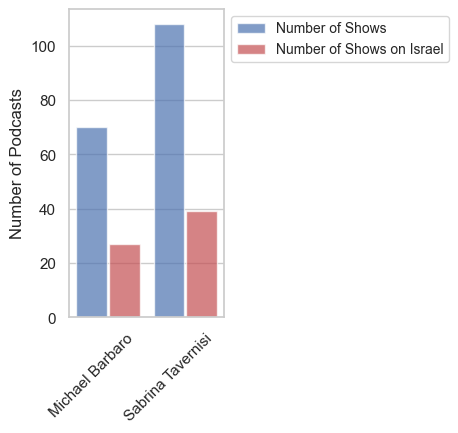

In [12]:
# make a grouped bar plot for the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
# and the number of rows with the topic word with max_fuzzy > 0.9
# make a plot as to the number of rows with 'Michael Barbaro' vs. 'Sabrina Tavern' with max_fuzzy > 0.9
sns.set_theme(style="whitegrid")
plt.figure(figsize=(2, 4))
hosts = target_word_list[:2]
topic = target_word_list[2]
# for each host find the number of rows with max_fuzzy > 0.9 and plot
for h_idx, host in enumerate(hosts):
	spacing = 0
	if h_idx > 0:
		spacing = 1
	# find the number of rows with max_fuzzy > 0.9 for the host
	host_df = transcript_df[transcript_df[f'max_fuzzy_{host}'] > 0.85]
	# find the number of rows with max_fuzzy > 0.9 for the topic
	topic_df = host_df[host_df[f'max_fuzzy_{topic}'] > 0.85]
	num_shows = host_df.shape[0]
	num_shows_topic = topic_df.shape[0]
	# plot as double bar graph with host and topic
	if h_idx == 0:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7, label='Number of Shows')
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7, label=f'Number of Shows on {topic}')
	else:
		plt.bar(h_idx+spacing, num_shows, color='b', alpha=0.7)
		plt.bar(h_idx+spacing+0.85, num_shows_topic, color='r', alpha=0.7)
plt.xticks([0, 2], hosts)
# rotate the x-axis labels
plt.xticks(rotation=45)
# legend outside of box outer right and smaller font size using bbox_to_anchor
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.ylabel('Number of Podcasts')
# only keep horizontal grid
plt.grid(axis='x')

In [1]:
import whisper
# see version of whisper
print(whisper.__version__)

20231117
